     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 35.9 MB/s eta 0:00:00:00:010:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1

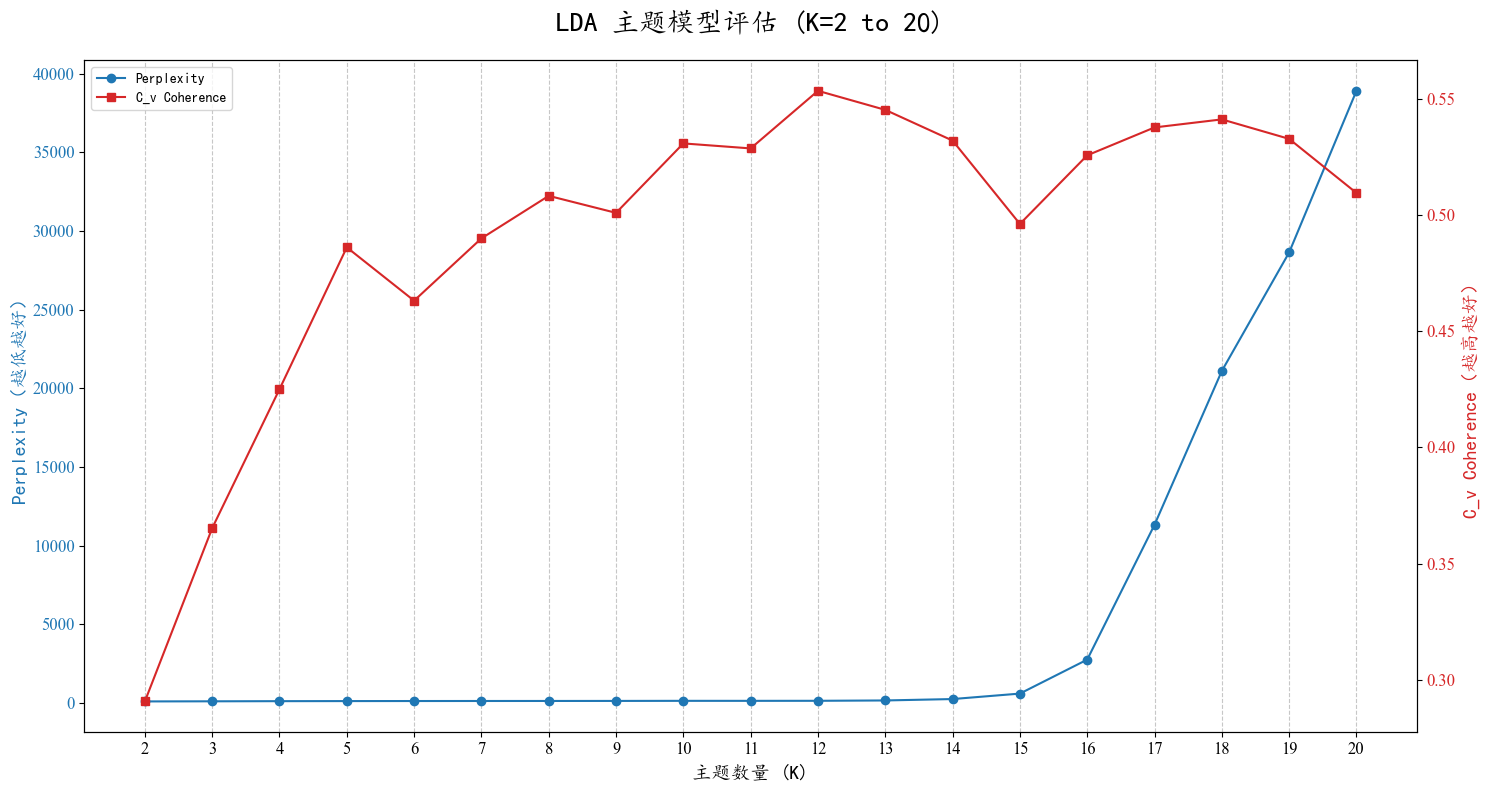

所有任务完成。


In [1]:
# --- 0. 安装必要的库 ---
# LDA和Coherence需要 'gensim' 库（需开启 Kaggle Internet）
!pip install -q gensim

# --- 1. 导入库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import sys
import re

# 导入 gensim
try:
    from gensim.corpora import Dictionary
    from gensim.models import LdaModel, CoherenceModel
except ImportError:
    print("错误：无法导入 gensim，请先成功安装。")
    sys.exit()

# --- 2. 设置字体和文件路径 ---
font_path_chinese = "/kaggle/input/nsfc2025-management/simkai.ttf"
font_path_english = "/kaggle/input/nsfc2025-management/times.ttf"
data_file = "/kaggle/input/nsfc2025-management/nsfc-2025-management-title-fenci.csv"

# 字体检查与注册
if os.path.exists(font_path_chinese):
    ch_font = fm.FontProperties(fname=font_path_chinese)
    fm.fontManager.addfont(font_path_chinese)
else:
    print(f"警告: 未找到中文字体 '{font_path_chinese}'，将使用系统默认中文字体。")
    ch_font = fm.FontProperties()

if os.path.exists(font_path_english):
    en_font = fm.FontProperties(fname=font_path_english)
    fm.fontManager.addfont(font_path_english)
else:
    print(f"警告: 未找到英文字体 '{font_path_english}'，将使用系统默认英文字体。")
    en_font = fm.FontProperties()

plt.rcParams['axes.unicode_minus'] = False 

# --- 3. 加载和准备数据（仅两列：项目名称、项目名称分词） ---
print(f"正在从 '{data_file}' 加载数据...")
try:
    df = pd.read_csv(data_file, dtype=str, encoding="utf-8")
except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。")
    sys.exit()
except Exception as e:
    print(f"读取CSV文件时出错: {e}")
    sys.exit()

# 统一去除列名两端空格
df.columns = [str(c).strip() for c in df.columns]

required_cols = {"项目名称", "项目名称分词"}
if not required_cols.issubset(set(df.columns)):
    print(f"错误：数据中缺少必需列。需要列：{required_cols}，当前列：{list(df.columns)}")
    sys.exit()

# 仅保留两列并清洗
df = df.loc[:, ["项目名称", "项目名称分词"]].dropna(subset=["项目名称分词"]).copy()

# 准备文本数据（按空格分词）
texts_raw = df["项目名称分词"].apply(lambda x: str(x).split()).tolist()
if not texts_raw:
    print("错误：分词文本为空。")
    sys.exit()

print(f"共找到 {len(texts_raw)} 篇文档。")

# --- 4. 文本预处理（移除停用词） ---
my_stop_words = {'研究', '机制', '基于', '影响', '优化', '效应', '视角', '策略', 
                 '驱动', '理论', '机理', '路径', '动态', '分析', '应用', '作用', 
                 '模型', '方法', '评估', '及其', '设计', '中国', '模式', '形成', 
                 '发展', '结构', '系统', '背景', '提升', '后果', '实证', '考虑', 
                 '问题', '建模', '面向', '测度', '效果', '预测', '识别', '构建', 
                 '关键', '传导', '——'}
print(f"将从文本中移除 {len(my_stop_words)} 个自定义停用词...")

texts_processed = [
    [w for w in doc if w not in my_stop_words]
    for doc in texts_raw
]

if not any(texts_processed):
    print("错误：移除停用词后所有文档均为空。")
    sys.exit()
print("停用词移除完成。")

# --- 创建 Gensim 词典和语料库（使用处理后的文本） ---
print("正在创建 Gensim 词典和语料库...")
id2word = Dictionary(texts_processed)

# 过滤极端词
id2word.filter_extremes(no_below=2, no_above=0.5)

corpus = [id2word.doc2bow(text) for text in texts_processed]
if not any(corpus):
    print("错误：语料库为空，可能是过滤条件过于严格。")
    sys.exit()

print(f"词典和语料库创建完成。词典大小(过滤后): {len(id2word)}")

# --- 5. LDA 主题模型评估循环 ---
K_range = range(2, 21)  # K∈[2,20]
perplexity_scores = []
coherence_scores_cv = []

print(f"开始 LDA 评估循环 (K=2 到 {max(K_range)})...")
for k in K_range:
    print(f"  正在计算 K={k}...")
    lda_model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=k,
        random_state=2025,
        passes=10,
        chunksize=100
    )
    # a. Perplexity（越低越好）
    log_perplexity = lda_model.log_perplexity(corpus)  # 每词平均对数似然
    perplexity = np.exp2(-log_perplexity)              # Perplexity = 2^(-log_perplexity)
    perplexity_scores.append(perplexity)

    # b. C_v Coherence（越高越好）— 用原始（未去停用词）文本计算更贴近可读性
    coherence_model_cv = CoherenceModel(
        model=lda_model,
        texts=texts_raw,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence_cv = coherence_model_cv.get_coherence()
    coherence_scores_cv.append(coherence_cv)

    print(f"    K={k}: Perplexity={perplexity:.3f}, C_v Coherence={coherence_cv:.3f}")

print("LDA 评估循环完成。")

# --- 6. 绘制评估指标图表 ---
print("正在生成评估图表...")
fig, ax1 = plt.subplots(figsize=(15, 8))

# 标题（不再依赖学科字段）
plt.title('LDA 主题模型评估 (K=2 to 20)', fontproperties=ch_font, fontsize=20, pad=20)

# X轴
ax1.set_xlabel('主题数量 (K)', fontproperties=ch_font, fontsize=14)
ax1.set_xticks(list(K_range))
plt.setp(ax1.get_xticklabels(), fontproperties=en_font, fontsize=12)

# Y轴1：Perplexity（越低越好）
color1 = 'tab:blue'
ax1.set_ylabel('Perplexity（越低越好）', fontproperties=ch_font, fontsize=14, color=color1)
line1 = ax1.plot(K_range, perplexity_scores, 'o-', color=color1, label='Perplexity')
ax1.tick_params(axis='y', labelcolor=color1)
plt.setp(ax1.get_yticklabels(), fontproperties=en_font, fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7, axis='x')

# Y轴2：C_v Coherence（越高越好）
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('C_v Coherence（越高越好）', fontproperties=ch_font, fontsize=14, color=color2)
line2 = ax2.plot(K_range, coherence_scores_cv, 's-', color=color2, label='C_v Coherence')
ax2.tick_params(axis='y', labelcolor=color2)
plt.setp(ax2.get_yticklabels(), fontproperties=en_font, fontsize=12)

# 合并图例
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='best', prop=ch_font, fontsize=12)

fig.tight_layout()

# --- 7. 显示和保存图表 ---
output_filename = 'lda_metrics.png'
fig = plt.gcf()

try:
    fig.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"图表已成功保存为: {output_filename} (位于 /kaggle/working/ 目录)")
except Exception as e:
    print(f"保存图表 '{output_filename}' 时出错: {e}")

try:
    print("正在显示图表：LDA 评估")
    plt.show()
except Exception as e:
    print(f"显示图表时出错: {e}")

plt.close(fig)
print("所有任务完成。")


In [2]:
print("K=12")

K=12
